<a href="https://colab.research.google.com/github/Thanwarin/robot-webots/blob/tmp/emotion_detection_Evaluation_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow keras opencv-python mediapipe --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [3]:
!wget -q https://gitlab.ecs.vuw.ac.nz/harisushehu/emotion-recognition-using-cnn/-/raw/master/dataset/fer2013.csv -O fer2013.csv

In [4]:
# ==============================
# Imports
# ==============================
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Config
# ==============================
IMG_SIZE = 96
NUM_CLASSES = 7
BATCH_SIZE = 16
emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# ==============================
# Load FER2013 CSV
# ==============================
data = pd.read_csv('fer2013.csv')
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['emotion'])

# ==============================
# Preprocess function
# ==============================
def preprocess_image(pixel_sequence):
    """Convert pixel string to 96x96 RGB image normalized [0,1]"""
    arr = np.array([int(p) for p in pixel_sequence.split() if p.strip().isdigit()])
    if arr.size != 48*48:
        return None
    img_gray = arr.reshape(48,48).astype('float32')
    img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    return img_rgb / 255.0

def preprocess_dataframe(df):
    X, y = [], []
    for _, row in df.iterrows():
        img = preprocess_image(row['pixels'])
        if img is not None:
            X.append(img)
            y.append(row['emotion'])
    X = np.array(X, dtype='float32')
    y = to_categorical(y, num_classes=NUM_CLASSES)
    return X, y

# ==============================
# Load Model from Google Drive
# ==============================
def load_model_from_drive(path):
    """Load saved .h5 model from Google Drive"""
    model = load_model(path)
    return model

# ==============================
# Evaluation Framework
# ==============================
def evaluate_model(model, X_val, y_val, labels=emotion_labels):
    """Evaluate a model and print metrics"""
    y_pred_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = np.mean(y_pred == y_true)
    print(f"Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

# ==============================
# Example Usage
# ==============================
# Preprocess validation set
X_val, y_val = preprocess_dataframe(val_df)

# Load model from Google Drive
# ให้ mount Google Drive ก่อนใน Colab: from google.colab import drive; drive.mount('/content/drive')

/content/drive/MyDrive/ml_models/emotion_model.h5


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 48, 48, 3), found shape=(32, 96, 96, 3)

/content/drive/MyDrive/ml_models/emotion_model_v3.h5


Accuracy: 0.5897

Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.47      0.48       991
     Disgust       0.66      0.46      0.54       109
        Fear       0.53      0.43      0.47      1024
       Happy       0.72      0.81      0.77      1798
         Sad       0.46      0.44      0.45      1216
    Surprise       0.71      0.74      0.73       800
     Neutral       0.52      0.56      0.54      1240

    accuracy                           0.59      7178
   macro avg       0.59      0.56      0.57      7178
weighted avg       0.58      0.59      0.58      7178



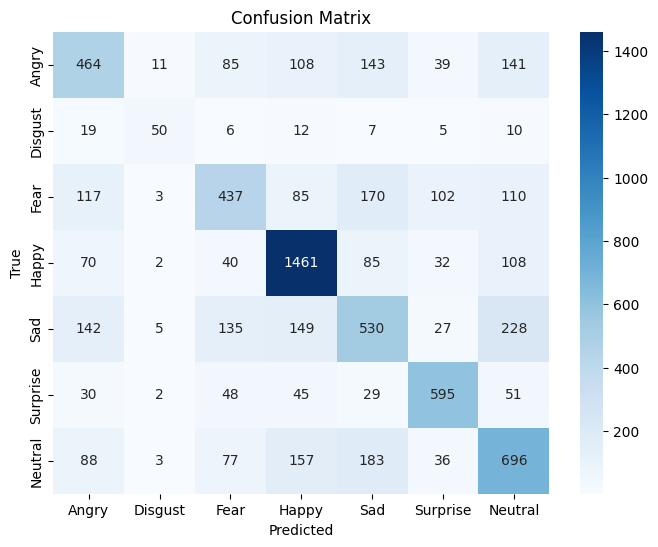

/content/drive/MyDrive/ml_models/emotion_model_ver4.h5


Accuracy: 0.5936

Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.50      0.50       991
     Disgust       0.64      0.48      0.55       109
        Fear       0.50      0.46      0.48      1024
       Happy       0.76      0.78      0.77      1798
         Sad       0.47      0.50      0.48      1216
    Surprise       0.70      0.75      0.73       800
     Neutral       0.54      0.52      0.53      1240

    accuracy                           0.59      7178
   macro avg       0.59      0.57      0.58      7178
weighted avg       0.59      0.59      0.59      7178



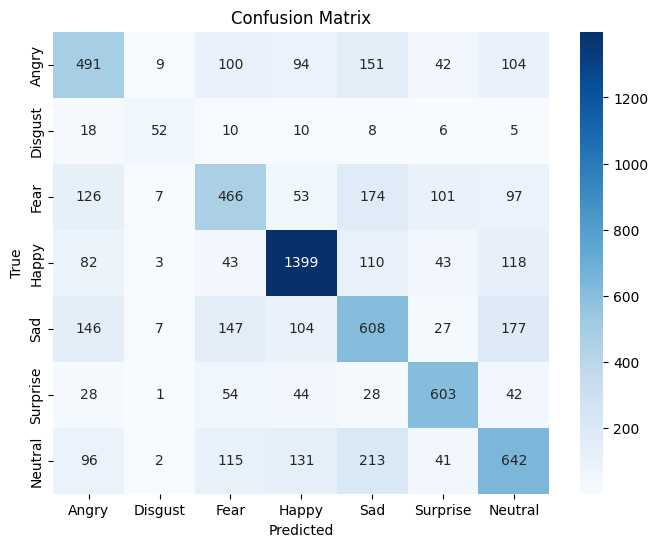

In [8]:
for i in ['_v3', '_ver4']:
  model_path = f"/content/drive/MyDrive/ml_models/emotion_model{i}.h5"
  print(model_path)

  drive_model = load_model_from_drive(model_path)
  # Evaluate
  evaluate_model(drive_model, X_val, y_val)

In [16]:
def preprocess_image_for_model(pixel_sequence, target_size=(48,48)):
    """Resize pixel sequence to target_size and convert to RGB normalized"""
    arr = np.array([int(p) for p in pixel_sequence.split() if p.strip().isdigit()])
    if arr.size != 48*48:
        return None
    img_gray = arr.reshape(48,48).astype('float32')
    img_resized = cv2.resize(img_gray, target_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    return img_rgb / 255.0

def preprocess_dataframe_for_model(df, model):
    """Preprocess dataframe according to model input shape"""
    input_shape = model.input_shape  # (None, H, W, C)
    H, W = input_shape[1], input_shape[2]
    X, y = [], []
    for _, row in df.iterrows():
        img = preprocess_image_for_model(row['pixels'], target_size=(W,H))
        if img is not None:
            X.append(img)
            y.append(row['emotion'])
    X = np.array(X, dtype='float32')
    y = to_categorical(y, num_classes=len(emotion_labels))
    return X, y

def evaluate_model_ver2(model, df_val, labels=emotion_labels):
    """Evaluate a model on dataframe, auto-adjust input size"""
    X_val, y_val = preprocess_dataframe_for_model(df_val, model)
    y_pred_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = np.mean(y_pred == y_true)
    print(f"Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

/content/drive/MyDrive/ml_models/emotion_model.h5


Accuracy: 0.5121

Classification Report:
              precision    recall  f1-score   support

       Angry       0.53      0.34      0.42       991
     Disgust       0.18      0.02      0.03       109
        Fear       0.25      0.37      0.30      1024
       Happy       0.86      0.75      0.80      1798
         Sad       0.38      0.47      0.42      1216
    Surprise       0.49      0.81      0.61       800
     Neutral       0.61      0.31      0.42      1240

    accuracy                           0.51      7178
   macro avg       0.47      0.44      0.43      7178
weighted avg       0.55      0.51      0.51      7178



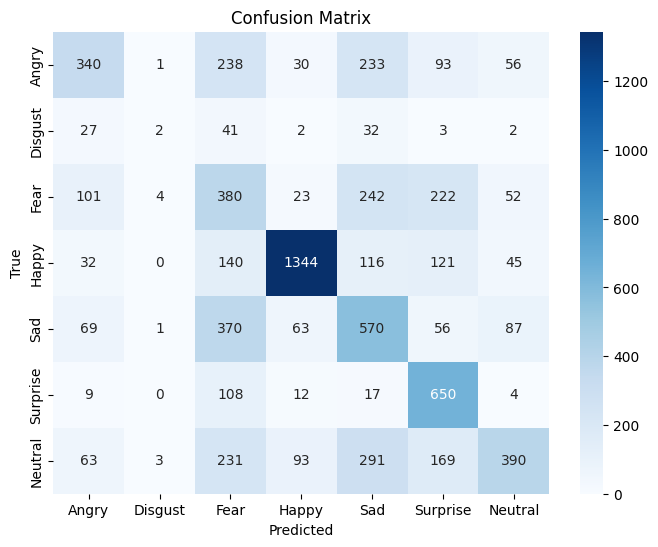

In [17]:
for i in ['']:
  model_path = f"/content/drive/MyDrive/ml_models/emotion_model{i}.h5"
  print(model_path)

  drive_model = load_model(model_path)
  # Evaluate

  evaluate_model_ver2(drive_model, val_df)

In [ ]:
# model_path = '/content/drive/MyDrive/emotion_model.h5'
# drive_model = load_model_from_drive(model_path)

# # Evaluate
# evaluate_model(drive_model, X_val, y_val)
